In [1]:
## Readme

# This is an implementation of Liu et al. (2018)
# - https://www.sciencedirect.com/science/article/abs/pii/S0022509618303223

# The results are exact.


In [2]:
## Packages
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import tqdm.autonotebook

/tmp/ipykernel_14499/2776281390.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook


In [3]:
## Useful functions

def evaluate_function(u, x):
    """[summary]
        Helps evaluated a function at a point `x` in parallel
    Args:
        u ([dolfin.Function]): [function to be evaluated]
        x ([Union(tuple, list, numpy.ndarray)]): [point at which to evaluate function `u`]
    Returns:
        [numpy.ndarray]: [function evaluated at point `x`]
    """
    comm = u.function_space().mesh().mpi_comm()
    if comm.size == 1:
        return u(*x)

    # Find whether the point lies on the partition of the mesh local
    # to this process, and evaulate u(x)
    cell, distance = msh.bounding_box_tree().compute_closest_entity(Point(*x))
    u_eval = u(*x) if distance < DOLFIN_EPS else None

    # Gather the results on process 0
    comm = msh.mpi_comm()
    computed_u = comm.gather(u_eval, root=0)

    # Verify the results on process 0 to ensure we see the same value
    # on a process boundary
    if comm.rank == 0:
        global_u_evals = np.array(
            [y for y in computed_u if y is not None], dtype=np.double)
        assert np.all(np.abs(global_u_evals[0] - global_u_evals) < 1e-9)

        computed_u = global_u_evals[0]
    else:
        computed_u = None

    # Broadcast the verified result to all processes
    computed_u = comm.bcast(computed_u, root=0)

    return computed_u

def local_project(v, V):
    """[summary]
        Helper function to do a local projection element-wise
        Useful for DG-spaces since the projection can be done
        for all the elements in parallel
    Args:
        v ([dolfin.Funcion]): [function to be projected]
        V ([dolfin.Function]): [target `dolfin.FunctionSpace` to be projected on]
    Returns:
        [dolfin.Function]: [target function after projection]
    """
    dv = TrialFunction(V)
    v_ = TestFunction(V)
    a_proj = inner(dv, v_) * dx(metadata=metadata)
    b_proj = inner(v, v_) * dx(metadata=metadata)
    solver = LocalSolver(a_proj, b_proj)
    solver.factorize()
    u = Function(V)
    solver.solve_local_rhs(u)
    return u

def asTensor(A):
    """
    [Input]    A : array (n,n)   [Array]
    
    [Output]   T : Tensor (n,n)  [ListTensor]
    """
    dim = A.shape[0]
    if dim == 2:
        T = as_tensor([[float(A[0][0]),float(A[0][1])],[float(A[1][0]),float(A[1][1])],[float(A[2][0]),float(A[2][1])]])
    elif dim == 3:
        T = as_tensor([[float(A[0][0]),float(A[0][1]),float(A[0][2])],
                       [float(A[1][0]),float(A[1][1]),float(A[1][2])],
                       [float(A[2][0]),float(A[2][1]),float(A[2][2])]])
    else:
        print('Error dimension')
    ##
    return T

In [4]:
## Mesh
dimx, dimy , dimz = 1, 0.5, 1
nx, ny, nz        = 1, 1, 1
mesh              = BoxMesh(Point(0.0, 0.0, 0.0), Point(dimx, dimy, dimz), nx,ny,nz)

gdim = mesh.geometry().dim() # geometry dimension
tdim = mesh.topology().dim() # topology dimension
fdim = tdim - 1              # facet dimension

In [5]:
## Facets identification
facets = MeshFunction('size_t', mesh, fdim)
left  = AutoSubDomain(lambda x: near(x[0], 0))     # Plane x = 0
right = AutoSubDomain(lambda x: near(x[0], dimx))  # Plane x = 1
back  = AutoSubDomain(lambda x: near(x[2], 0))     # Plane z = 0   
front = AutoSubDomain(lambda x: near(x[2], dimz))  # Plane z = 1
bot   = AutoSubDomain(lambda x: near(x[1], 0))     # Plane y = 0
top   = AutoSubDomain(lambda x: near(x[1], dimy))  # Plane y = 1

facets.set_all(0)

left.mark(facets, 1)
right.mark(facets, 2)
back.mark(facets, 3)   
front.mark(facets, 4) 
bot.mark(facets, 5)
top.mark(facets, 6)

In [6]:
## Integration
dx   = Measure('dx', mesh)
ds   = Measure('ds', mesh, subdomain_data=facets)

In [7]:
## Approximation space
W     = VectorFunctionSpace(mesh, "CG", 1)
u     = Function(W) 
u_    = TestFunction(W)
du    = TrialFunction(W) 

ET0   = FunctionSpace(mesh, "CG", 1)  
ET2   = TensorFunctionSpace(mesh, "DG",0)

In [8]:
## Material parameters
tau1, tau2   = 1.0   , 1.0
beta1, beta2 = 1.0   , 1.0  #0.000001
k, c         = 1e6   , 0.877   #[kPa,kPa] 
k1, k2       = 0.154 , 34.157  #[kPa,-] 
tau1, tau2   = 1.0    , 1.0
etaM         = 1.5
etaF         = 1.5

dt = 0.1 # [s]

In [9]:
## Fibers configuration
theta  = np.radians(0.0)
a0     = as_vector([cos(theta),sin(theta),0]) 
A0     = outer(a0,a0)     

In [10]:
## Internal variables
invCmv = Function(ET2, name = "[(Cᵐᵥ)⁻¹]ⁿ⁺¹")
I4e_   = Function(ET0, name = "[Ī₄ₑ]ⁿ⁺¹")
I4v    = Function(ET0, name = "[I₄ᵥ]ⁿ⁺¹")

In [11]:
## Initial Values
I4v  = Constant(1.0)            # [I₄ᵥ]⁰ = 1 
I4v_ = Constant(1.0)            # [Ī₄ᵥ]⁰ = 1 

invCmv.assign(project(Identity(gdim), ET2))  # [(Cᵐᵥ)⁻¹]⁰ = I
I4e_.assign(Constant(1.0))      # [Ī₄ₑ]⁰  = 1   

In [12]:
def FreeEnergy(Ie_,I4e_):
    """ 
    [Input]    u     : [u]ⁿ          (displacement field)  
               I4e_  : [I₄ₑᶦˢᵒ]ⁿ     (fiber)
                 
    [Output]   Ψₙ₊₁  : Free Energy function 
    """   

    ## Free Energy 
    PSImeq    = Constant(c)*(I1_-Constant(3))                                          # Bien
    PSIfeq    = Constant(k1/(2*k2))*(exp(Constant(k2)*(I4_-1)**2)-Constant(1))         # Bien
    PSImvs    = Constant(beta1)*Constant(c)*(Ie_-Constant(3))
    PSIfvs    = Constant(beta2*k1/(2*k2))*(exp(Constant(k2)*(I4e_-1)**2)-Constant(1))  
    PSIpen    = Constant(0.5*k)*(J-1)**2                                               # Bien
    return PSImeq + PSIfeq + PSIpen + PSImvs + PSIfvs
    ### end 

In [13]:
def PK2(invCmv,I4_,I4e_):
    """
    [Input]   I4_         : [I₄ᶦˢᵒ]ⁿ⁺¹      
              I4e_        : [I₄ₑᶦˢᵒ]ⁿ⁺¹    
    
    [Output]  S           : [S]ⁿ (2nd Piola-Kirchhoff)
    """ 

    ##
    Siso_eq  = 2*c*(J**(-2/3))*(I-1/3*I1*inv(C))
    Sani_eq  = 2*k1*(I4_-1)*exp(k2*(I4_-1)**2)*(J**(-2/3))*I4_*(A0/I4_-1/3*inv(C_))
    Siso_vis = 2*beta1*c*(J**(-2/3))*(invCmv-1/3*inner(C,invCmv)*inv(C))
    Sani_vis = 2*beta2*k1*(I4e_-1)*exp(k2*(I4e_-1)**2)*(J**(-2/3))*I4e_*(A0/I4_-1/3*inv(C_))
    Spen     = k*(J**2-J)*inv(C)

    return Siso_eq, Siso_vis, Sani_eq, Sani_vis, Spen  

In [14]:
def ViscoEvolution(C,C_,invCmv0,I4v0,point,dt):
    """
    Liu et al. (2019) numerical implementation
    
    [Input]      C      :   [C]ⁿ⁺¹     
                 C_     :   [Cᶦˢᵒ]ⁿ⁺¹   
                 invCmv0   :   [(Cᵐᵥ)⁻¹]ⁿ  
                 I4v0   :   [I₄ᵥ]ⁿ      
                 point  :   any tuple (relaxation condition)
                 
    [Output]     Cmv   :   [(Cᵐᵥ)⁻¹]ⁿ⁺¹
                 I4v   :   [I₄ᵥ]ⁿ⁺¹     
                 I4e_  :   [Ī₄ₑ]ⁿ⁺¹    
                 alpha :   α            
    """
    from scipy import optimize
    
    # ~~~~~~~~ Algorithm 1: Cmv0 = [(Cᵐᵥ)⁻¹]ⁿ known                                  
    C_inv_coeff = local_project(inv(C), ET2)          # [Coefficient]
    C_inv      = np.reshape(C_inv_coeff(point),[3,3]) # [Array]
    
    C_mv_inv0 =  np.reshape(evaluate_function(local_project(invCmv0,ET2),point),[3,3])  # [(Cᵐᵥ)⁻¹]ⁿ [Array]   
    
    # Newton-Raphson or Secant method
    
    #dt = 0.1
    alpha0 = 0
    F      = lambda alpha: np.linalg.det(tau1/(tau2+dt)*(C_mv_inv0+alpha*dt*C_inv)) - 1 # Eq. 47 [Liu et al. (2019)]
    dF     = lambda alpha: np.linalg.det(tau1/(tau2+dt)*(C_mv_inv0+alpha*dt*C_inv))*\
                    np.trace(np.linalg.inv(tau1/(tau2+dt)*(C_mv_inv0+alpha*dt*C_inv))*dt*C_inv)
    alpha  = optimize.newton(F, alpha0, fprime=dF,tol=1e-6,maxiter=100)
    
    # [(Cᵐᵥ)⁻¹]ⁿ⁺¹                    
    C_mv_inv  = tau1/(tau2+dt)*(C_mv_inv0+alpha*dt*C_inv)  
    C_mv_inv  = asTensor(C_mv_inv)                                 # [(Cᵐᵥ)⁻¹]ⁿ⁺¹  [ListTensor]
    
    # ~~~~~~~~ Algorithm 2: [I₄]ⁿ, [I₄ᵥ]ⁿ, and [I₄ᵥᶦˢᵒ]ⁿ are known
    
    # Equilibrium part
    A0I4v = A0/I4v0
    I4E0  = inner(C_,A0I4v)       # [Ī₄ₑ]ⁿ   Eq. 50      
   
    I4e_coeff  = project(I4E0,ET0)                   # [Coefficient]
    I4_escalar = np.reshape(I4e_coeff(point),[1,1])  # [Array]
   
    # Newton-Raphson or Secant method (use only dF) -   Halley’s method (use also d2F)
    x0   = I4_escalar[0][0] # initial value x₀ = [Ī₄ₑ]ⁿ
    a    = dt/tau2
    FF   = lambda x: x+a*x*(x-1)/(x*(1+2*k2*(x-1)*(x-1))+(x-1))-x0 # Eq. 49 
    dF   = lambda x: a*(-2*k2*x**4+4*k2*x**3+2*x**2-2*k2*x**2-2*x+1)/(-2*k2*x**3+4*k2*x**2-2*k2*x-2*x+1)**2+1
    d2F  = lambda x:(-2*a*(-1+4*k2**2*(-1+x)**3*x**3-2*k2*(1-6*x+12*x**2-13*x**3+6*x**4)))/(1-2*(1+k2)*x+4*k2*x**2-2*k2*x**3)**3
    I4E_ = optimize.newton(FF, x0, fprime=dF, fprime2=d2F,tol=1e-6,maxiter=100)
            
    I4E_ = Constant(I4E_) 
      
    # Viscous part           
    I4_ = inner(C_,A0) # [Ī₄]ⁿ⁺¹  
    I4V = I4_/I4E_     # [I₄ᵥ]ⁿ⁺¹ = [Ī₄]ⁿ⁺¹/[Ī₄ₑ]ⁿ⁺¹  Eq. 13.5
    I4V = project(I4V,ET0)        # [I₄ᵥ]ⁿ⁺¹ (Coefficient)
    
    return C_mv_inv, I4V, I4E_, alpha
    # --------------------------------------------------------------------------

In [15]:
## Dirichlet BC
bc1 = DirichletBC(W.sub(0), Constant(0.), left)  # x = 0 >> UX = 0
bc2 = DirichletBC(W.sub(2), Constant(0.), back)  # z = 0 >> UZ = 0
bc3 = DirichletBC(W.sub(1), Constant(0.), bot)  # y = 0 >> UY = 0

disp = Expression(('rate*time_'),rate = 0.0, time_=0.0 , degree=0)

bc4 = DirichletBC(W.sub(0), disp, right) # x = 1 >> UX = disp
bc5 = DirichletBC(W.sub(2), disp, front) # z = 1 >> UZ = disp

bcs = [bc1,bc2,bc3,bc4,bc5]

In [16]:
## Neumann BC
B  = Constant((0.0, 0.0, 0.0))   # Body force/unit volume
T  = Constant((0.0, 0.0, 0.0))   # Traction force

In [17]:
## Kinematics 
I = Identity(u.geometric_dimension())   # Identity tensor
F = variable(I + grad(u))               # [Variable][Coefficient]
C = F.T*F                               # [Variable][Coefficient]
b = F*F.T                               # [Variable][Coefficient]
J = det(F)                              # [Variable][Coefficient]
F_ = J**(-1/3)*F
C_ = F_.T*F_
b_ = F_*F_.T  

# Invariants
I1  =  tr(C)
I1_ = J**(-2/3)*I1

I4  = inner(C,A0) # dot(a0,C*a0)
I4_ = inner(C_,A0) #J**(-2/3)*I4

Ie  = inner(C,invCmv)
Ie_ = inner(C_,invCmv)

In [18]:
## solver parameters
set_log_level(30)
parameters["linear_algebra_backend"] = "PETSc"
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["quadrature_degree"] = 2  # Orden de interpolacion
parameters["form_compiler"]["representation"] = "uflacs"
#parameters["form_compiler"]["representation"] = "tsfc"
parameters["ghost_mode"] = "shared_facet"

ffc_options = {"optimize": True,
            "eliminate_zeros": True,
            "precompute_basis_const": True,
            "precompute_ip_const": True}

metadata = {"quadrature_degree": 2}  # Integration points
snes_solver_parameters = {"nonlinear_solver": "snes",
                        "snes_solver": {"linear_solver": "cg",
                                        "preconditioner": "ilu",
                                        "maximum_iterations": 100,
                                        "report": True,
                                        "line_search": 'bt',
                                        "error_on_nonconvergence": False,
                                        "relative_tolerance": 1e-8,
                                        "absolute_tolerance": 1e-8}}

In [19]:
## Weak form - variational problem
Pi = FreeEnergy(Ie_,I4e_)*dx - dot(B, u)*dx - dot(T, u)*ds(4)

DPi = derivative(Pi, u, u_)           
Jac = derivative(DPi, u, du)        

problem = NonlinearVariationalProblem(DPi, u, bcs=bcs, J=Jac)
solver = NonlinearVariationalSolver(problem)
solver.parameters.update(snes_solver_parameters)

In [20]:
## Iteration setup
tTotal =  8
Nsteps = int(tTotal/dt+1)
Time   = np.linspace(0, tTotal, Nsteps)
j      = 1

ufinal     = 0.1
disp.rate  = dimx*ufinal

px = (dimx,dimy/2,dimz/2)
pz = (dimx/2,dimy/2,dimz)
pt = px

## Storage
disp_v        = np.zeros((Nsteps,1))
SIG_v         = np.zeros((Nsteps,1))
SIGeq_v       = np.zeros((Nsteps,1))
SIGneq_v      = np.zeros((Nsteps,1))
invariants    = np.zeros((Nsteps,4))

In [21]:
## Simulation
progress = tqdm.autonotebook.tqdm(desc="Solving simulation", total=Nsteps)

# ---------------------------------------------------- #
for i, d in enumerate(Time):
    progress.update(1)
    
    # ~~~~~~ Relaxation control ~~~~~~ # 
    if Time[i] <= 1:
        disp.time_ = d
    else:
        disp.time_ = Time[i-j]
        j += 1

    
    # ~~~~~~ Solve FEM ~~~~~~ #
    # Input: [u]ⁿ, [(Cᵐᵥ)⁻¹]ⁿ, [I₄ₑᶦˢᵒ]ⁿ    # Ouput: [u]ⁿ⁺¹
    
    solver.solve()
    
    disp_v[i] = u(pt)[0]
    
    # ~~~~~~ Internal variables
    INVCMV, I4v, I4E_, alpha = ViscoEvolution(C,C_,invCmv,I4v,pt,dt)   # [(Cᵐᵥ)⁻¹]ⁿ⁺¹, [I₄ᵥ]ⁿ⁺¹, [Ī₄ₑ]ⁿ⁺¹, α
    
    invCmv.assign(local_project(INVCMV,ET2))  # [(Cᵐᵥ)⁻¹]ⁿ⁺¹ (Coefficient)
    I4e_.assign(I4E_)        # [Ī₄ₑ]ⁿ⁺¹     (Coefficient)
    
    # ~~~ Cauchy Stress for analysis ~~~ #
    Sniso_eq, Sniso_vis, Snani_eq, Snani_vis, Svol = PK2(invCmv,I4_,I4e_)  
    Sn                   = inv(J)*F*(Sniso_eq + Sniso_vis + Snani_eq + Snani_vis + Svol)*F.T
    Seq                  = inv(J)*F*(Sniso_eq + Snani_eq + Svol)*F.T
    Svs                  = inv(J)*F*(Sniso_vis + Snani_vis)*F.T
    #
    SIG_v[i]         = np.reshape(evaluate_function(local_project(Sn, ET2),pt),[3,3])[0][0]
    SIGeq_v[i]       = np.reshape(evaluate_function(local_project(Seq, ET2),pt),[3,3])[0][0]
    SIGneq_v[i]      = np.reshape(evaluate_function(local_project(Svs, ET2),pt),[3,3])[0][0]

    # ~~~ Invariants for analysis ~~~ #
    invariants[i,0] = np.reshape(evaluate_function(project(I1_,ET0),pt),[1,1])[0][0] # I1 iso
    invariants[i,1] = np.reshape(evaluate_function(project(Ie_,ET0),pt),[1,1])[0][0]    # Ie iso
    invariants[i,2] = np.reshape(evaluate_function(project(I4_,ET0),pt),[1,1])[0][0]    # I4 iso
    invariants[i,3] = np.reshape(evaluate_function(I4e_,pt),[1,1])[0][0]       # I4e iso    


Solving simulation:   0%|          | 0/81 [00:00<?, ?it/s]

  0 SNES Function norm 1.026333650647e-16 
  0 SNES Function norm 1.054090052190e+04 
  1 SNES Function norm 1.623654300786e+02 
  2 SNES Function norm 2.867697774652e-07 
  0 SNES Function norm 1.064631631620e+04 
  1 SNES Function norm 1.623232556269e+02 
  2 SNES Function norm 2.934830908629e-07 
  0 SNES Function norm 1.075173160720e+04 
  1 SNES Function norm 1.622819185576e+02 
  2 SNES Function norm 3.036279969996e-07 
  0 SNES Function norm 1.085714643216e+04 
  1 SNES Function norm 1.622414119426e+02 
  2 SNES Function norm 3.191750625608e-07 
  0 SNES Function norm 1.096256081413e+04 
  1 SNES Function norm 1.622017393809e+02 
  2 SNES Function norm 3.440301079516e-07 
  0 SNES Function norm 1.106797475646e+04 
  1 SNES Function norm 1.621629230010e+02 
  2 SNES Function norm 3.841492403164e-07 
  0 SNES Function norm 1.117338823257e+04 
  1 SNES Function norm 1.621250183785e+02 
  2 SNES Function norm 4.508306799380e-07 
  0 SNES Function norm 1.127880116639e+04 
  1 SNES Fu

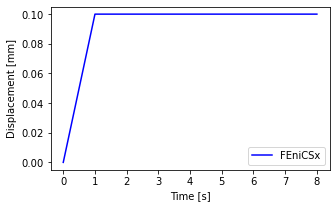

In [22]:
## Dispacement
f = plt.figure(figsize=(5,3))
plt.plot(Time,  disp_v,'b-',label='FEniCSx')

plt.xlabel('Time [s]')
plt.ylabel('Displacement [mm]')
plt.legend()
plt.show()

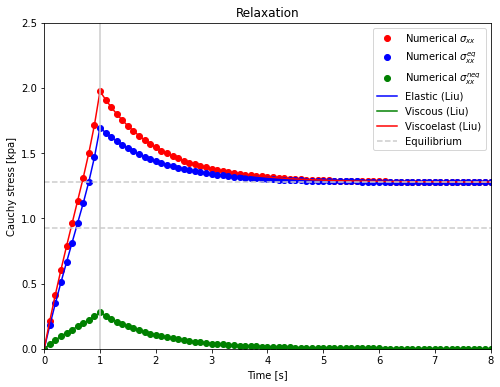

In [23]:
## Stresses
f = plt.figure(figsize=(8,6))

## FEniCSx
plt.plot(Time, SIG_v,'ro',label='Numerical $\sigma_{xx}$')
plt.plot(Time, SIGeq_v,'bo',label='Numerical $\sigma^{eq}_{xx}$')
plt.plot(Time, SIGneq_v,'go',label='Numerical $\sigma^{neq}_{xx}$')

## Liu et al.(2019)
LiuStress = np.loadtxt("data/stress.txt")

plt.plot(LiuStress[:,0], LiuStress[:,1],'b-',label='Elastic (Liu)')
plt.plot(LiuStress[:,0], LiuStress[:,2],'g-',label='Viscous (Liu)')
plt.plot(LiuStress[:,0], LiuStress[:,3],'r-',label='Viscoelast (Liu)')

plt.axhline(y=1.2808, color='0.8', linestyle='--', label = 'Equilibrium') 
plt.axhline(y=0.9293, color='0.8', linestyle='--')
plt.axvline(x = 1, color = '0.8') # Line y = 0

plt.xlabel('Time [s]')
plt.ylabel('Cauchy stress [kpa]')
plt.title('Relaxation')
plt.legend()
plt.axis([0, 8, 0, 2.5])
plt.show()

Text(0.5, 1.0, 'I4e iso')

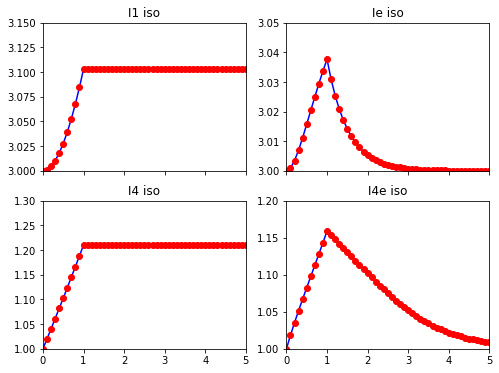

In [24]:
## Invariants

invariantsInfo = np.loadtxt("data/invariants.txt")
Time0  = invariantsInfo[:,0]
I1iso  = invariantsInfo[:,1]
Ieiso  = invariantsInfo[:,2]
I4iso  = invariantsInfo[:,3]
I4eiso = invariantsInfo[:,4]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True,figsize=(8,6))
ax1.plot(Time0, I1iso,'b-')
ax1.plot(Time, invariants[:,0],'ro')
ax1.axis([0, 5, 3, 3.15])
ax1.set_title('I1 iso')

ax2.plot(Time0, Ieiso,'b-')
ax2.plot(Time, invariants[:,1],'ro')
ax2.axis([0, 5, 3, 3.05])
ax2.set_title('Ie iso')

ax3.plot(Time0, I4iso,'b-')
ax3.plot(Time, invariants[:,2],'ro')
ax3.axis([0, 5, 1, 1.3])
ax3.set_title('I4 iso')

ax4.plot(Time0, I4eiso,'b-')
ax4.plot(Time, invariants[:,3],'ro')
ax4.axis([0, 5, 1, 1.2])
ax4.set_title('I4e iso')